In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from functools import reduce
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [168]:
pops = ['AFR', 'EUR', 'EAS', 'AMR', 'SAS']

def read_files(chrom, n_files, truncated, n_truncated=None):
    #rsids = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/dbsnp/snps/rsids_{chrom}.txt", 
    #            sep = "\t", header = None)
    tags_all_pop = []
    for pop in pops:
        tags = pd.DataFrame(columns = ['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS', f'LD_{pop}'])
        for i in range(n_files):
            df = pd.read_csv(f"files/chr{chrom}_{i}_{pop}_tag_info.txt", sep = "\t", header = None)
            df.columns = ['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS', f'LD_{pop}']
            df[f'LD_{pop}'] = df[f'LD_{pop}']**2
            df[f'LD_{pop}'] = df[f'LD_{pop}'].round(2)
            df = df.drop_duplicates(['CHROM', 'TR_POS'])
            #df = pd.merge(df, rsids[[1,2]], left_on=f'{pop}_TAG_SNP_POS', right_on=[1], how = "left")
            #df = df[['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS', 2, f'LD_{pop}']]
            #df.columns = ['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS','rsID', f'LD_{pop}']
            tags = pd.concat([tags,df])
        tags_all_pop.append(tags)
    ALL = reduce(lambda  left,right: pd.merge(left, right, on=['CHROM','TR_POS'],
                                             how='outer'), tags_all_pop)
    ALL['TR_POS'] = ALL['TR_POS'].astype(int)
    
    
    
    if truncated:
        tags_all_pop_truncated = []
        
        for pop in pops:
            tags = pd.DataFrame(columns = ['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS', f'LD_{pop}'])
            for i in range(n_truncated):
                df = pd.read_csv(f"files/chr{chrom}_{i}_{pop}_tag_info_last.txt", sep = "\t", header = None)
                df.columns = ['CHROM', 'TR_POS', f'{pop}_TAG_SNP_POS', f'LD_{pop}']
                df[f'LD_{pop}'] = df[f'LD_{pop}']**2
                df[f'LD_{pop}'] = df[f'LD_{pop}'].round(2)
                df = df.drop_duplicates(['CHROM', 'TR_POS'])
                tags = pd.concat([tags,df])
            tags_all_pop_truncated.append(tags)
        
        ALL_truncated = reduce(lambda  left,right: pd.merge(left, right, on=['CHROM','TR_POS'],
                                             how='outer'), tags_all_pop_truncated)
        ALL_truncated['TR_POS'] = ALL_truncated['TR_POS'].astype(int)
    
        ALL = pd.concat([ALL, ALL_truncated])
        ALL = ALL.drop_duplicates(['CHROM', 'TR_POS'])
    ALL = ALL.fillna("NA")
    ALL.to_csv(f'tag_files/tag_snp_info_chr{chrom}_hg38.csv', index=False)
    return ALL.sort_values('TR_POS')



In [190]:
ALL = read_files(5, 7, False, 5)
ALL

,CHROM,TR_POS,AFR_TAG_SNP_POS,LD_AFR,EUR_TAG_SNP_POS,LD_EUR,EAS_TAG_SNP_POS,LD_EAS,AMR_TAG_SNP_POS,LD_AMR,SAS_TAG_SNP_POS,LD_SAS
55387,chr5,50354,NA,NA,NA,NA,NA,NA,13719,0.5,NA,NA
0,chr5,66687,66696,0.46,66696,1,66696,0.87,66696,0.53,66696,0.71
1,chr5,67390,49902,0.93,67389,0.25,73367,0.17,67389,0.45,NA,NA
52676,chr5,109565,NA,NA,NA,NA,109564,0.66,NA,NA,NA,NA
2,chr5,118793,118798,1,118798,0.89,118798,1,118798,1,118798,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...
44075,chr5,181263339,181263338,1,181238405,0.25,NA,NA,181263338,1,181263338,0.72
44076,chr5,181264244,181264243,0.97,181218265,0.57,181300847,0.33,181264243,0.69,181227923,0.5
55386,chr5,181264727,NA,NA,NA,NA,181264726,1,NA,NA,NA,NA
44077,chr5,181269031,181234274,0.03,181269030,1,NA,NA,181269030,0.17,181269030,0.76


In [180]:
means = []


def common_alleles(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    for afreq in afreqs:
        if float(afreq.split(":")[1]) > 0.01:
            cnt += 1   
    return cnt


for chrom in range(1,23):
    if chrom == 12:
        continue
    pop_means = []
    for pop in ['EUR']:
        stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr{chrom}_{pop}.tab", 
                            sep = "\t")
        stats.drop_duplicates(subset=['chrom','start'])
        stats['chrom'] = stats['chrom'].astype(str)
        stats['common_alleles'] = stats.apply(lambda x: common_alleles(x['afreq-1']), axis = 1)

        tags = pd.read_csv(f'tag_files/tag_snp_info_chr{chrom}_hg38.csv')
        stats_tags = pd.merge(stats, tags, left_on = ['chrom','start'], right_on = ['CHROM', 'TR_POS'])
        stats_tags = stats_tags[stats_tags['common_alleles'] == 5]
        pop_means.append(pd.to_numeric(stats_tags[f'LD_{pop}'],errors='coerce').mean())
        
    means.append(np.mean(pop_means))
 
        
        
    
    

In [181]:
np.mean(means)

0.6811323093527701

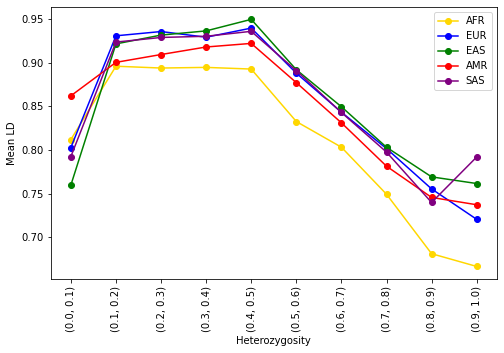

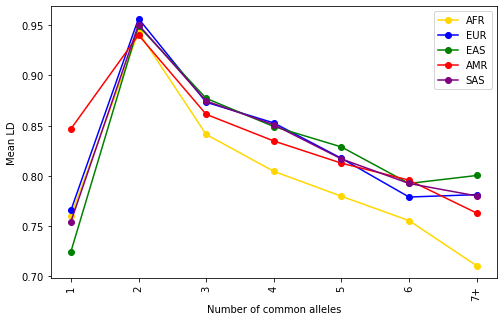

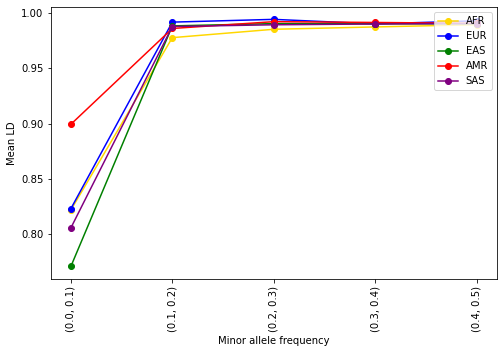

In [3]:
popcolors = {}
popcolors["AFR"] = "gold"
popcolors["AMR"] = "red"
popcolors["EAS"] = "green"
popcolors["EUR"] = "blue"
popcolors["SAS"] = "purple"


def common_alleles(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    for afreq in afreqs:
        if float(afreq.split(":")[1]) > 0.01:
            cnt += 1   
    return cnt

def minor_allele(afreqs):
    if afreqs == ".":
        return np.nan
    afreqs = afreqs.split(",")
    cnt = 0
    if len(afreqs) == 2:
        freq1 = float(afreqs[0].split(":")[1])
        freq2 = float(afreqs[1].split(":")[1])
        return min(freq1, freq2)
    return np.nan  



fig, ax = plt.subplots(figsize=(8, 5))
fig2, ax2 = plt.subplots(figsize=(8, 5))
fig3, ax3 = plt.subplots(figsize=(8, 5))


keys = []
for i in range(10):
    keys.append((i/10,(i+1)/10))
    
    
ma_keys = []
for i in range(5):
    ma_keys.append((i/10,(i+1)/10))
for i in range(len(pops)):
    pop = pops[i]
    
    stats = pd.read_csv(f"/expanse/projects/gymreklab/helia/ensembl/experiments/allele_freq/freqs/freqs_chr21_{pop}.tab", 
                        sep = "\t")
    stats.drop_duplicates(subset=['chrom','start'])
    stats['chrom'] = stats['chrom'].astype(str)
    stats['common_alleles'] = stats.apply(lambda x: common_alleles(x['afreq-1']), axis = 1)
    stats['minor_allele'] = stats.apply(lambda x: minor_allele(x['afreq-1']), axis = 1)

    tags = tag_dict[pop]
    stats_tags = pd.merge(stats, tags, left_on = ['chrom','start'], right_on = ['chrom', 'str_pos'])
    stats_tags_grouped = stats_tags.groupby("common_alleles", as_index=False).agg({'abs_LD': np.mean})
    plus_7 = np.mean(stats_tags[stats_tags['common_alleles'] > 6]['abs_LD'])
    stats_tags_grouped = stats_tags_grouped[stats_tags_grouped['common_alleles'] < 7]
    stats_tags_grouped.loc[len(stats_tags_grouped.index)] = [7, plus_7] 
    #print(stats_tags_grouped, pop)
    het_dict = {}
    for i in range(10):
        het_dict[i] = []
        
    for index,row in stats_tags.iterrows():
        het_dict[int(row['het-1'] * 10)].append(row['abs_LD'])
        
    for key in het_dict:
        het_dict[key] = np.nanmean(het_dict[key])  
        

    minor_allele_dict = {}
    for i in range(5):
        minor_allele_dict[i] = []

    for index,row in stats_tags.iterrows():
        if ~np.isnan(row['minor_allele']):
            minor_allele_dict[min(int(row['minor_allele'] * 10),4)].append(row['abs_LD'])

    for key in minor_allele_dict:
        minor_allele_dict[key] = np.nanmean(minor_allele_dict[key])  
        
    
    ax.plot(het_dict.keys(), het_dict.values(), marker= "o", label = pop,  color = popcolors[pop])
    ax2.plot(stats_tags_grouped.common_alleles, stats_tags_grouped.abs_LD, 
             marker= "o", label = pop,  color = popcolors[pop])
    ax3.plot(minor_allele_dict.keys(), minor_allele_dict.values(), marker= "o", label = pop,  color = popcolors[pop]) 
    
ax.xaxis.set_ticks(np.arange(0, 10, 1))
ax.set_xticklabels(keys,rotation='vertical')
ax.set_ylabel("Mean LD")
ax.set_xlabel("Heterozygosity")
ax.legend(loc="upper right")  

ax2.xaxis.set_ticks(np.arange(1, 8, 1))
ax2.set_xticklabels([str(x) for x in np.arange(1, 7, 1)] + ["7+"] ,rotation='vertical')
ax2.set_ylabel("Mean LD")
ax2.set_xlabel("Number of common alleles")
ax2.legend(loc="upper right")  
fig2.savefig("pdfs/common_allele_vs_LD.pdf", dpi=1200)
   
ax3.xaxis.set_ticks(np.arange(0, 5, 1))
ax3.set_xticklabels(ma_keys,rotation='vertical')
ax3.set_ylabel("Mean LD")
ax3.set_xlabel("Minor allele frequency")
ax3.legend(loc="upper right") 

[Text(1, 0, '(0.0, 0.1)'),
 Text(2, 0, '(0.1, 0.2)'),
 Text(3, 0, '(0.2, 0.3)'),
 Text(4, 0, '(0.3, 0.4)'),
 Text(5, 0, '(0.4, 0.5)'),
 Text(6, 0, '(0.5, 0.6)'),
 Text(7, 0, '(0.6, 0.7)'),
 Text(8, 0, '(0.7, 0.8)'),
 Text(9, 0, '(0.8, 0.9)'),
 Text(10, 0, '(0.9, 1.0)'),
 Text(11, 0, '(1.0, 1.1)')]

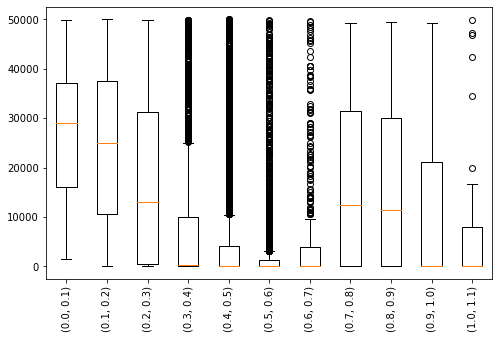

In [99]:
keys = []
for i in range(11):
    keys.append((i/10,(i+1)/10))
dist_dict = {}
for i in range(11):
    dist_dict[i] = []

for index,row in tags.iterrows():
    if ~np.isnan(row['abs_LD']):
        dist_dict[int(row['abs_LD'] * 10)].append(abs(row['str_pos'] - row['snp_pos']))
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(dist_dict.values())
ax.set_xticklabels(keys,rotation='vertical')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


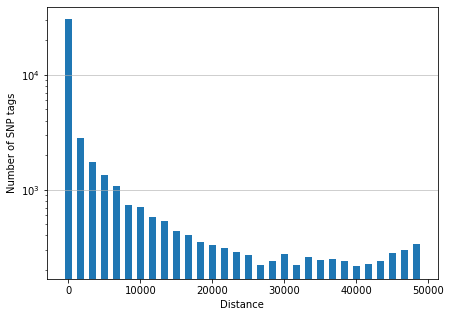

In [12]:
distances = []
fig, ax = plt.subplots(figsize=(7, 5))
for pop in tag_dict:
    tags = tag_dict[pop]
    distances.extend(list((tags['snp_pos'] - tags['str_pos']).abs()))

hist_vals, bin_edges = np.histogram(distances, bins = 30)
ax.grid(axis='y', alpha=0.75)
ax.bar(bin_edges[0:len(hist_vals)], hist_vals, width=1000, bottom = 0, log = True)


ax.set_xlabel("Distance")
ax.set_ylabel("Number of SNP tags")
fig.savefig("pdfs/Number_vs_dist.pdf", dpi=1200)